# How to optimize error-robust Mølmer–Sørensen gates for trapped ions
**Efficient state preparation using Mølmer–Sørensen-type interactions**

Boulder Opal enables you to efficiently prepare quantum states of trapped ion qubits using Mølmer–Sørensen-type interactions.
In this notebook we show how to find both optimal and robust control drives to create a (multi-particle) entangled state using specific functions designed for trapped-ion experiments.

The interaction Hamiltonian for Mølmer–Sørensen-type operations is in the form of
$$ H(t) = i\frac{\hbar}{2} \sum_{j=1}^N \sigma_{x, j} \sum_{p=1}^{3N} \eta_{pj} \left( 
        \gamma_{j}(t) e^{i \delta_p t} a_{p}^\dagger - \gamma^\ast_{j}(t) e^{-i \delta_p t} a_p \right)  ,
$$
where $N$ is the number of ions, $\sigma_x$ is the Pauli $X$ operator, $a_p$ is the annihilation operator for the mode $p$, $\eta_{pj}$ is the Lamb–Dicke parameter of mode $p$ for the ion $j$, $\delta_p=\nu_p-\delta$ is the relative detuning of the laser frequency from the motional frequency of mode $p$, and $\gamma_j(t)$ is the drive applied ion the ion $j$.

Mølmer–Sørensen-type operations can be used to entangle multiple ions using pairs of lasers with opposite detunings and a fixed phase relationship.
For these operations, the laser detuning should be close to a motional mode frequency, and the displacements in the phase-space of each mode should be small.
At the end of the operation, the phase-space trajectories for each mode should return to zero (for no residual state-motional entanglement) and the phase acquired between each pair of ions should correspond to target entangling phases $\psi_{jk}$ between each pair of ions ($j$, $k$), indexing from 0:
$$ U = \exp\left(i \sum_{j=1}^{N-1} \sum_{k=0}^{j-1} \psi_{jk} \sigma_x^j \sigma_x^k \right). $$

The objective of the gate-design process is to find definitions for the different drives $\gamma_j(t)$ which ensure high-fidelity gates which decouple all motional modes from the qubit degree of freedom.
Gates may be designed to accumulate entangling phase either using interaction with only a single mode, or multiple modes.
Note that multiple entangling operations can be performed in parallel, including multi-qubit entangling operations.

## Summary workflow

### 1. Define and calculate ion properties

To find optimized drives, you first need to know the physical properties of the ions, namely the Lamb–Dicke parameters and mode frequencies.
You can calculate these values using the function `boulderopal.ions.obtain_ion_chain_properties` by providing basic parameters of your ion trap:
```python
bo.ions.obtain_ion_chain_properties(
    atomic_mass, ion_count, center_of_mass_frequencies, wavevector, laser_detuning
)
```

The function returns the Lamb–Dicke parameters and relative detunings as a dictionary, which will be used in the phase and displacement calculations for ions.

### 2. Optimize drives

Next you need to set up the optimization properties.
Define drives accessible in your system (for example, individual-ion beams with programmable moduli and phases) as described in the [robust optimization tutorial](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs).
The drives are typically piecewise-constant, where the amplitude and phase take constant values for each pulse segment of the given laser drive.
A programmable drive can be specified within a graph as follows:
```python
ion_drive = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count, maximum=drive_moduli_max, duration=duration
)
```

Using the Lamb–Dicke parameters and relative detunings calculated above, particular drives give rise to [relative phases](https://doi.org/10.1002/qute.202000044) and [phase space displacements](https://doi.org/10.1002/qute.202000044) during an operation.
You can calculate these gate properties using the `graph.ions.ms_phases` and `graph.ions.ms_displacements` graph operations, which can be obtained for a specified array of `sample_times`:
```python
ms_phases = graph.ions.ms_phases(
    drives, lamb_dicke_parameters, relative_detunings, sample_times
)
ms_displacements = graph.ions.ms_displacements(
    drives, lamb_dicke_parameters, relative_detunings, sample_times
)
```

The [operational infidelity](https://doi.org/10.1002/qute.202000044) of the gate is determined by the relative phases and displacements at the final time of the drives.
You can obtain the infidelity using the `graph.ions.ms_infidelity` operation:
```python
infidelity = graph.ions.ms_infidelity(
    phases=ms_phases[-1], displacements=ms_displacements[-1], target_phases=target_phases
)
```

Note that you need to format the target phases as a strictly lower triangular matrix (see the notes of the `graph.ions.ms_phases` operation for details).
With this infidelity as the cost function, you can find the optimal drives using the Boulder Opal optimization engine.

Visualize your optimized drives using [`plot_controls`](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer/plot_controls.html) from the Q-CTRL Visualizer package.

**Note**: a piecewise-constant control pulse can produce control frequencies that bring undesired transitions into resonance.
To suppress these transitions for piecewise-constant controls, a low-pass filter can be applied to a given solution to eliminate these high-frequency components, typically with negligible fidelity loss.
Alternatively, the segment durations of piecewise-constant controls can be selected to be multiples of the carrier detuning period.
More generally, smooth controls can be optimized such that control frequency components lie below the carrier detuning, for instance using a sinc filter as demonstrated in the [Designing robust, configurable, parallel gates for large trapped-ion arrays](https://docs.q-ctrl.com/boulder-opal/application-notes/designing-robust-configurable-parallel-gates-for-large-trapped-ion-arrays) application note, and in the [How to add smoothing and band-limits to control optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-add-smoothing-and-band-limits-to-optimized-controls) user guide.


### 3. Optimize drives for error-robustness

You may also seek to produce error-robust gates which exhibit resilience against common noise sources (for example, laser-detuning noise).
Robustness to these noise sources is given by imposing a combination of symmetry in each ion's drive, as described in ([Milne et al., Phys. Rev. Applied, 2020](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.024022)), and optimization such that the centre of mass of each mode's trajectory is at zero.
A detailed discussion is given in [Bentley et al. (2020)](https://doi.org/10.1002/qute.202000044), and this robust control protocol to create the Bell state has also been recently demonstrated experimentally, as shown in [Milne et al. (2020)](https://doi.org/10.1103/PhysRevApplied.13.024022).

You can optimize robust operations by both imposing symmetry in the drives, as demonstrated in the following examples, and by including the optimization cost term `graph.ions.ms_dephasing_robust_cost` to calculate the final displacement of each mode's centre of mass and use it in the Boulder Opal optimization engine to find the robust controls:
```python
robust_cost_term = graph.ions.ms_dephasing_robust_cost(
    drives, lamb_dicke_parameters, relative_detunings,
)
cost = infidelity + robust_cost_term
```


### 4. Validate performance
#### Calculate phase-space displacement, relative phase, and infidelity dynamics
Given the controls, you can visualize the trajectory of the center of a coherent state in (rotating) optical phase space for each mode.
The closure of these trajectories is a necessary condition for an effective operation.

You can return the mode displacements from the `graph.ions.ms_displacements` operation within your optimization, for the specified `sample_times`.
The results of the `graph.ions.ms_displacements` operation describe contributions to each mode's displacement from each ion.
To get the overall displacement for each mode, you need to sum over the ion dimension (see the notes of `graph.ions.ms_displacements` operation for details):
```python
trajectories = np.sum(result["output"]["displacements"]["value"], axis=3)
```

To change the `sample_times` with a given optimized control, you can calculate the `graph.ions.ms_displacements` function within our flexible `qctrl.functions.calculate_graph` function, as shown in the [How to calculate system dynamics for arbitrary Mølmer–Sørensen gates](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-system-dynamics-for-arbitrary-molmer-sorensen-gates) user guide.

The same procedures can be applied to track how relative phases for each ion pair and infidelity change during the gate operational time, using `graph.ions.ms_phases` and `graph.ions.ms_infidelity`, respectively.
For high-fidelity operations, the relative phase obtained at the end of the operation should match the target phase for each ion pair.

#### Calculate robustness to dephasing and pulse timing errors with quasi-static scans

You can assess the robustness of the 'Robust' optimized pulses in comparison to the 'Standard' optimized pulses using 1D quasi-static scans.
By introducing a quasi-static offset of your choice, such as detuning, you can adapt and calculate the `graph.ions.ms_displacements` and `graph.ions.ms_phases` terms in the graph, which determine the error-dependent `graph.ions.ms_infidelity`.

## Example: Optimal and robust Mølmer–Sørensen gates for two-qubit gates
Here we explore a simple example in which we define optimal and robust control solutions implementing a Mølmer–Sørensen gate on a pair of Ytterbium ions.

### Define and calculate ion properties

For multi-qubit operations, first specify the number and type of ions, as well as other trap and laser characteristics, and collect the Lamb–Dicke parameters and relative detunings from the result.
These will be used in the phase and displacement calculations for ions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define trap and laser characteristics.
ion_count = 2
maximum_rabi_rate = 2 * np.pi * 100e3
laser_detuning = 1.6e6 + 4.7e3

# Collect Lamb–Dicke parameters as an array of shape [<axis>, <collective_mode>, <ion>]
# and relative detunings as an array of shape [<axis>, <collective_mode>].
ion_chain_properties = bo.ions.obtain_ion_chain_properties(
    atomic_mass=171,  # Yb ions
    ion_count=ion_count,
    center_of_mass_frequencies=[1.6e6, 1.5e6, 0.3e6],
    wavevector=[(2 * np.pi) / 355e-9, (2 * np.pi) / 355e-9, 0],
    laser_detuning=laser_detuning,
)
lamb_dicke_parameters = ion_chain_properties["lamb_dicke_parameters"]
relative_detunings = ion_chain_properties["relative_detunings"]

Your task (action_id="1828728") has completed.


In [3]:
# Operation duration in seconds.
duration = 2e-4

# Target phases: element (j,k) is the relative entanglement for ions j and k (k<j).
target_phases = np.array([[0, 0], [np.pi / 4, 0]])

Now we establish the graph that represents this system, which is used in the optimization itself.
Note that in this example we have established functions to calculate both optimal and robust gates in the same codeblock.

In [4]:
# Helper function for robustness.
def reflect_signal(graph, moduli, phases, even_total_segment_count):
    """
    This function reflects a drive signal about its temporal midpoint
    (Milne et al., Phys. Rev. Applied, 2020).
    The combined signal is returned.
    """

    if even_total_segment_count:
        moduli_refl = graph.reverse(moduli, [0])
        phases_refl = graph.reverse(phases, [0])

    else:
        moduli_refl = graph.reverse(moduli[:-1], [0])
        phases_refl = graph.reverse(phases[:-1], [0])

    moduli_comb = graph.concatenate([moduli, moduli_refl], 0)
    phases_comb = graph.concatenate([phases, 2 * phases[-1] - phases_refl], 0)

    return moduli_comb, phases_comb


# Helper function for optimization with identical drives in all ions.
def optimization_with_identical_drives(
    ion_count,
    segment_count,
    duration,
    maximum_rabi_rate,
    lamb_dicke_parameters,
    relative_detunings,
    target_phases,
    sample_times,
    robust,
):
    graph = bo.Graph()

    # Specification of free variables and combination with reflected signal.
    if robust:
        free_segment_count = (segment_count + 1) // 2
    else:
        free_segment_count = segment_count

    # The drive moduli and phases are free variables here.
    # They could also be restricted or fixed.
    moduli = graph.optimization_variable(
        count=free_segment_count, lower_bound=0, upper_bound=maximum_rabi_rate
    )
    phases = graph.optimization_variable(
        count=free_segment_count,
        lower_bound=0,
        upper_bound=2 * np.pi,
        is_lower_unbounded=True,
        is_upper_unbounded=True,
    )

    if robust:
        moduli, phases = reflect_signal(graph, moduli, phases, segment_count % 2 == 0)

    ion_drive = graph.complex_pwc_signal(
        moduli=moduli, phases=phases, duration=duration, name="ion_drive"
    )

    drives = [ion_drive] * ion_count

    ms_phases = graph.ions.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="phases",
    )

    ms_displacements = graph.ions.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="displacements",
    )

    infidelities = graph.ions.ms_infidelity(
        phases=ms_phases,
        displacements=ms_displacements,
        target_phases=target_phases,
        name="infidelities",
    )

    infidelity = infidelities[-1]
    infidelity.name = "infidelity"

    if robust:
        robust_cost_term = graph.ions.ms_dephasing_robust_cost(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )
        cost = infidelity + robust_cost_term
    else:
        cost = infidelity + 0

    cost.name = "cost"

    return bo.run_optimization(
        graph=graph,
        optimization_count=4,
        cost_node_name="cost",
        output_node_names=[
            "ion_drive",
            "phases",
            "displacements",
            "infidelities",
            "infidelity",
        ],
    )


# Helper function for optimization with different drives for each ion.
def optimization_with_different_drives(
    segment_count,
    duration,
    maximum_rabi_rate,
    lamb_dicke_parameters,
    relative_detunings,
    target_phases,
    sample_times,
    robust,
    drive_names,
):
    graph = bo.Graph()

    # Specification of free variables and combination with reflected signal.
    if robust:
        free_segment_count = (segment_count + 1) // 2
    else:
        free_segment_count = segment_count

    drives = []
    for drive_name in drive_names:
        # The drive moduli and phases are free variables here.
        # They could also be restricted or fixed.
        moduli = graph.optimization_variable(
            count=free_segment_count, lower_bound=0, upper_bound=maximum_rabi_rate
        )
        phases = graph.optimization_variable(
            count=free_segment_count,
            lower_bound=0,
            upper_bound=2 * np.pi,
            is_lower_unbounded=True,
            is_upper_unbounded=True,
        )

        if robust:
            moduli, phases = reflect_signal(
                graph, moduli, phases, segment_count % 2 == 0
            )

        drives.append(
            graph.complex_pwc_signal(
                moduli=moduli, phases=phases, duration=duration, name=drive_name
            )
        )

    ms_phases = graph.ions.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="phases",
    )

    ms_displacements = graph.ions.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="displacements",
    )

    infidelities = graph.ions.ms_infidelity(
        phases=ms_phases,
        displacements=ms_displacements,
        target_phases=target_phases,
        name="infidelities",
    )

    infidelity = infidelities[-1]
    infidelity.name = "infidelity"

    if not robust:
        cost = infidelity + 0
    else:
        robust_cost_term = graph.ions.ms_dephasing_robust_cost(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )
        cost = infidelity + robust_cost_term

    cost.name = "cost"

    return bo.run_optimization(
        graph=graph,
        optimization_count=4,
        cost_node_name="cost",
        output_node_names=["phases", "displacements", "infidelities", "infidelity"]
        + drive_names,
    )

### Optimize drives (optimal control solution)

Next, specify the control pulses according to the degrees of freedom in the hardware.
In this optimization, the complex drive $\gamma (t) = \Omega e^{i \phi}$ jointly addresses both ions in the chain.
Alternatively, separate drives can be optimized to individually address each ion; graph encodings for both approaches are provided above.
Here, the drives are defined by optimizable moduli and phases for individual segments (but note that, in general, you can define the drives using any of the techniques covered in the [Design robust single qubit gates using computational graphs](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) tutorial).

The optimizer attempts to minimize a particular cost.
The cost is specified in the below cell
to quantify the distances of the trajectory end-points from the origin, and the differences between the realized and target phases.
The infidelity also quantifies the solution performance.

Your task (action_id="1828729") has started.
Your task (action_id="1828729") has completed.
Cost = Infidelity = 1.493e-11


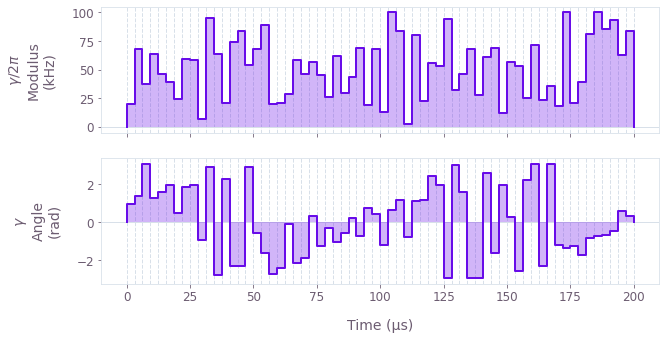

In [5]:
segment_count = 64
sample_times = np.linspace(0, duration, segment_count)

result_optimal = optimization_with_identical_drives(
    ion_count=ion_count,
    segment_count=segment_count,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    target_phases=target_phases,
    sample_times=sample_times,
    robust=False,
)

print(f"Cost = Infidelity = {result_optimal['output']['infidelity']['value']:.3e}")
qv.plot_controls({"$\\gamma$": result_optimal["output"]["ion_drive"]})

The above figure displays the optimized pulse modulus $\Omega (t)$ and phase $\phi (t)$ that addresses both ions.



### Optimize drives (robust control solution)

Next we show how to optimize the drives to obtain the maximally-entangled state for two ions affected by dephasing noise, which is common in experiments due to various noise sources, for example frequency fluctuations in control lasers.
The optimization procedure is extended by adding the robustness symmetry constraint and the calculation of `graph.ions.ms_dephasing_robust_cost` in the graph-based optimization; this is enabled in the helper function defined above by setting `robust=True`.

Your task (action_id="1828730") has started.
Your task (action_id="1828730") has completed.
Cost = 9.159e-12
Infidelity = 3.539e-12


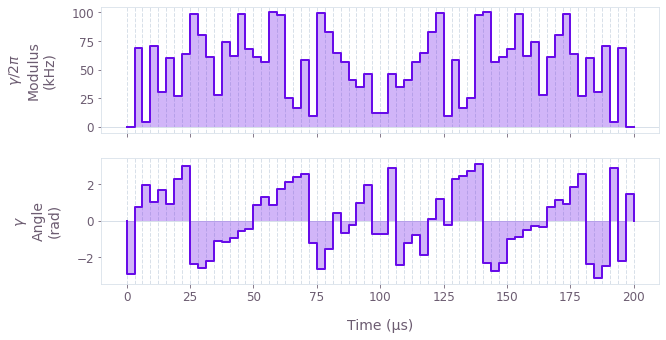

In [6]:
result_robust = optimization_with_identical_drives(
    ion_count=ion_count,
    segment_count=segment_count,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    target_phases=target_phases,
    sample_times=sample_times,
    robust=True,
)

print(f"Cost = {result_robust['cost']:.3e}")
print(f"Infidelity = {result_robust['output']['infidelity']['value']:.3e}")
qv.plot_controls({"$\\gamma$": result_robust["output"]["ion_drive"]})

The above figure displays the dynamics of the modulus and angle of the robust optimized pulse.
The symmetry in time of the modulus values can be observed.

### Validate performance
#### Calculate phase space trajectories

In [7]:
def plot_phase_space_trajectories(total_displacement, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plot_range = 1.1 * np.max(np.abs(total_displacement))
    fig.suptitle(f"Phase space trajectories ({title})", y=1.1)

    for k in range(2):
        for mode in range(ion_count):
            axs[k].plot(
                np.real(total_displacement[:, k, mode]),
                np.imag(total_displacement[:, k, mode]),
                label=f"mode {mode % 2}",
            )
            axs[k].plot(
                np.real(total_displacement[-1, k, mode]),
                np.imag(total_displacement[-1, k, mode]),
                "kx",
                markersize=15,
            )

        axs[k].set_xlim(-plot_range, plot_range)
        axs[k].set_ylim(-plot_range, plot_range)
        axs[k].set_aspect("equal")
        axs[k].set_xlabel("q")

    axs[0].set_title("$x$-axis")
    axs[0].set_ylabel("p")
    axs[1].set_title("$y$-axis")
    axs[1].yaxis.set_ticklabels([])

    hs, ls = axs[0].get_legend_handles_labels()
    fig.legend(
        handles=hs, labels=ls, loc="center", bbox_to_anchor=(0.5, 1), ncol=ion_count
    )

    plt.tight_layout()
    plt.show()

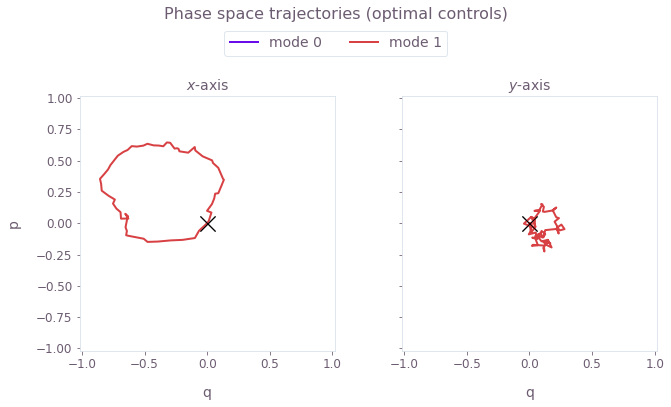

In [8]:
# Sum over ion index to obtain total displacement of the mode.
plot_phase_space_trajectories(
    np.sum(result_optimal["output"]["displacements"]["value"], axis=3),
    "optimal controls",
)

Here, $q \equiv q_m = (a_m^\dagger + a_m)/\sqrt{2}$ and $p \equiv p_m = i (a_m^\dagger - a_m)/\sqrt{2}$ are the dimensionless quadratures for each mode $m$.
The black cross marks the final displacement for each mode.
These are overlapping at zero, indicating no residual state-motional entanglement and no motional heating caused by the operations.
The z-axis modes are not addressed, and thus have no excursions in phase space.

Next visualize the phase space trajectories for the robust optimized control.

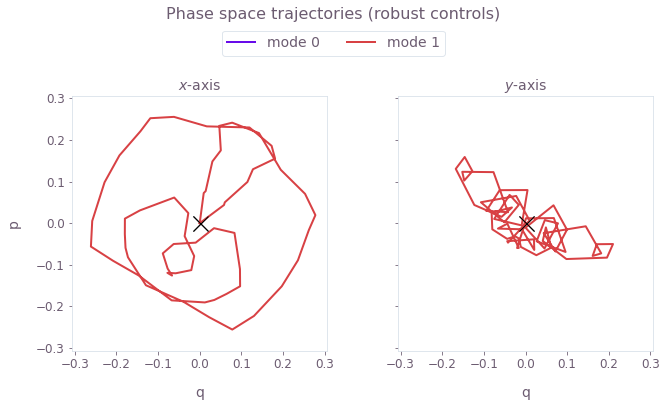

In [9]:
plot_phase_space_trajectories(
    np.sum(result_robust["output"]["displacements"]["value"], axis=3), "robust controls"
)

Here, the center of mass (the value of the integrated trajectory) for each mode is optimized to be close to the origin.
Again, the black crosses at the origin indicate no residual state-motional entanglement, which arises from satisfying the center of mass and symmetry conditions.

#### Calculate relative phase dynamics

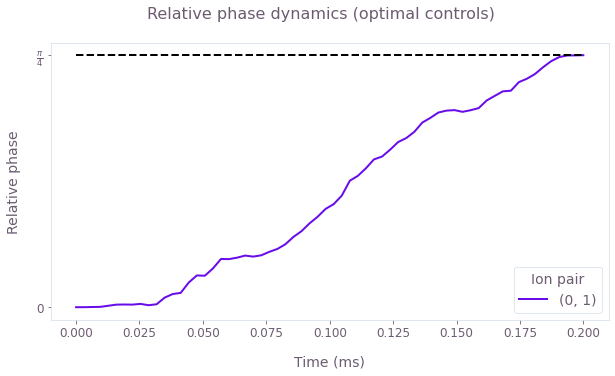

In [10]:
times = sample_times * 1e3
phases = result_optimal["output"]["phases"]["value"]

plt.figure(figsize=(10, 5))
plt.suptitle("Relative phase dynamics (optimal controls)")
plt.plot(times, phases[:, 1, 0], label="(0, 1)")
plt.plot([0, times[-1]], [np.pi / 4, np.pi / 4], "k--")
plt.yticks([0, np.pi / 4], ["0", r"$\frac{\pi}{4}$"])
plt.xlabel("Time (ms)")
plt.ylabel("Relative phase")
plt.legend(title="Ion pair")
plt.show()

The figure shows the dynamics of the relative phase between the two ions, over the duration of the gate.
Under the optimized control, this evolves from 0 to the target maximally-entangled phase of $\pi/4$ at the end of the operation.
The target phase is marked by the horizontal dashed black line.

Next obtain the phase accumulation for the robust optimized control.

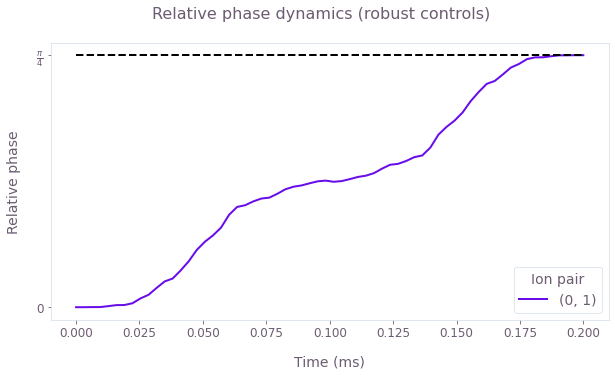

In [11]:
times = sample_times * 1e3
phases = result_robust["output"]["phases"]["value"]

plt.figure(figsize=(10, 5))
plt.suptitle("Relative phase dynamics (robust controls)")
plt.plot(times, phases[:, 1, 0], label="(0, 1)")
plt.plot([0, times[-1]], [np.pi / 4, np.pi / 4], "k--")
plt.yticks([0, np.pi / 4], ["0", r"$\frac{\pi}{4}$"])
plt.xlabel("Time (ms)")
plt.ylabel("Relative phase")
plt.legend(title="Ion pair")
plt.show()

By the end of the robust operation, the relative phase of the ions has reached the target value of $\pi/4$, marked by the dashed black line.

#### Calculate robustness to dephasing and pulse timing errors with quasi-static scans

You can assess the robustness of the 'Robust' optimized pulses in comparison to the 'Standard' optimized pulses using 1D quasi-static scans.
First consider a scan of scaling factors for the pulse timings.
The scaling factors are applied uniformly: they scale the timing for the entire operation by the same factor.

In [12]:
timing_scan_points = 21
max_timing_shift = 0.02
time_shifts = np.linspace(
    1 - max_timing_shift, 1 + max_timing_shift, timing_scan_points
)

optimal_infidelity_names = [
    f"infidelity_{number}" for number in range(timing_scan_points)
]
robust_infidelity_names = [
    f"robust_infidelity_{number}" for number in range(timing_scan_points)
]

graph = bo.Graph()

for result, infidelity_names in [
    (result_optimal, optimal_infidelity_names),
    (result_robust, robust_infidelity_names),
]:
    for time_shift, infidelity_name in zip(time_shifts, infidelity_names):
        ion_drive = graph.pwc_signal(
            values=result["output"]["ion_drive"]["values"],
            duration=duration * time_shift,
        )

        drives = [ion_drive] * 2

        ms_phases = graph.ions.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )

        ms_displacements = graph.ions.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )

        ms_infidelity = graph.ions.ms_infidelity(
            phases=ms_phases,
            displacements=ms_displacements,
            target_phases=target_phases,
            name=infidelity_name,
        )

timing_scan = bo.execute_graph(
    graph=graph, output_node_names=optimal_infidelity_names + robust_infidelity_names
)

optimal_infidelities_timing = [
    timing_scan["output"][name]["value"] for name in optimal_infidelity_names
]
robust_infidelities_timing = [
    timing_scan["output"][name]["value"] for name in robust_infidelity_names
]

Your task (action_id="1828731") has started.
Your task (action_id="1828731") has completed.


Next, calculate the robustness of the optimized pulses using a systematic scan of the relative detunings (which corresponds to shifting the laser detuning).

In [13]:
dephasing_scan_points = 21
max_dephasing_shift = 0.4 * np.min(np.abs(relative_detunings))
dephasing_shifts = np.linspace(
    -max_dephasing_shift, max_dephasing_shift, dephasing_scan_points
)

optimal_infidelity_names = [
    f"infidelity_{number}" for number in range(dephasing_scan_points)
]
robust_infidelity_names = [
    f"robust_infidelity_{number}" for number in range(dephasing_scan_points)
]

graph = bo.Graph()

for result, infidelity_names in [
    (result_optimal, optimal_infidelity_names),
    (result_robust, robust_infidelity_names),
]:
    for dephasing_shift, infidelity_name in zip(dephasing_shifts, infidelity_names):
        ion_drive = graph.pwc(**result["output"]["ion_drive"])
        drives = [ion_drive] * 2

        ms_phases = graph.ions.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings + dephasing_shift,
        )

        ms_displacements = graph.ions.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings + dephasing_shift,
        )

        ms_infidelity = graph.ions.ms_infidelity(
            phases=ms_phases,
            displacements=ms_displacements,
            target_phases=target_phases,
            name=infidelity_name,
        )

dephasing_scan = bo.execute_graph(
    graph=graph, output_node_names=optimal_infidelity_names + robust_infidelity_names
)

optimal_infidelities_dephasing = [
    dephasing_scan["output"][name]["value"] for name in optimal_infidelity_names
]
robust_infidelities_dephasing = [
    dephasing_scan["output"][name]["value"] for name in robust_infidelity_names
]

Your task (action_id="1828732") has started.
Your task (action_id="1828732") has completed.


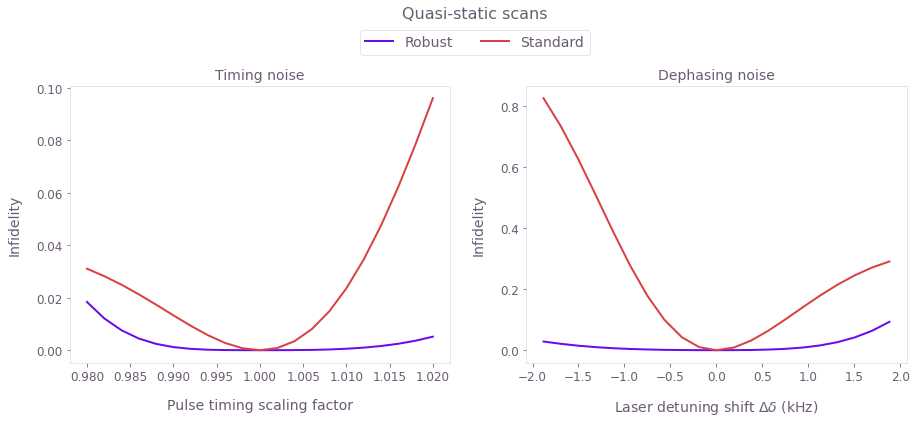

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Quasi-static scans", y=1.1)

axs[0].set_title("Timing noise")
axs[0].plot(time_shifts, robust_infidelities_timing, label="Robust")
axs[0].plot(time_shifts, optimal_infidelities_timing, label="Standard")
axs[0].set_xlabel("Pulse timing scaling factor")
axs[0].set_ylabel("Infidelity")

axs[1].set_title("Dephasing noise")
axs[1].plot(dephasing_shifts / 1e3, robust_infidelities_dephasing, label="Robust")
axs[1].plot(dephasing_shifts / 1e3, optimal_infidelities_dephasing, label="Standard")
axs[1].set_xlabel("Laser detuning shift $\\Delta \\delta$ (kHz)")
axs[1].set_ylabel("Infidelity")

hs, ls = axs[0].get_legend_handles_labels()
fig.legend(handles=hs, labels=ls, loc="center", bbox_to_anchor=(0.5, 1.0), ncol=2)

plt.show()

The broader high-fidelity region indicates the benefit of the robust optimized pulses when there is quasi-static dephasing noise or noise in the control pulse timings, demonstrating the utility of the robust solution.

## Example: GHZ state on a chain of three ions

In this example we consider a chain of three ions (${}^{171}{\rm Yb}^{+}$), and the goal is to find a set of drives such that, at the end of the drives, the relative phase between each ion pair is $\pi/4$.
Note that you can perform $X_{\pi/2}$ rotations for all ions after applying the optimal drives to create the GHZ state, as shown in [Kim et al. (2009)](https://doi.org/10.1103/PhysRevLett.103.120502).

### Define and calculate ion properties
We begin by calculating ion properties based on inputs relevant to the system under examination.

In [15]:
# Specify ion trap parameters.
ion_count = 3
atomic_mass = 171
center_of_mass_frequencies = [1.6e6, 1.5e6, 0.3e6]

# Laser characteristics.
wavevector = [1.8e7, 1.8e7, 0]
laser_detuning = 1.6047e6
maximum_rabi_rate = 2 * np.pi * 100e3

# Calculate ion chain properties.
ion_chain_properties = bo.ions.obtain_ion_chain_properties(
    atomic_mass=atomic_mass,
    ion_count=ion_count,
    center_of_mass_frequencies=center_of_mass_frequencies,
    wavevector=wavevector,
    laser_detuning=laser_detuning,
)
lamb_dicke_parameters = ion_chain_properties["lamb_dicke_parameters"]
relative_detunings = ion_chain_properties["relative_detunings"]

Your task (action_id="1828733") has completed.


### Optimize drives

In this example, the drive for each ion is defined by optimizable moduli and phases for individual segments (but note that, in general, you can define the drives using any of the techniques covered in the [Design robust single qubit gates using computational graphs](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) tutorials).
In this example we only seek an optimal solution rather than a robust solution.

In [16]:
# Set up the target phases as a strictly lower triangular matrix.
target_phases = (np.pi / 4) * np.tri(ion_count, k=-1)

# Number of optimizable PWC segments in the drives.
segment_count = 128

# Total durations of the drives.
duration = 2e-4

# Drive node names for retrieving the results.
drive_names = ["drive_" + str(i) for i in range(ion_count)]

sample_times = np.linspace(0, duration, 300)

optimization_result = optimization_with_different_drives(
    segment_count=segment_count,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    target_phases=target_phases,
    sample_times=sample_times,
    robust=False,
    drive_names=drive_names,
)

Your task (action_id="1828734") has started.
Your task (action_id="1828734") has completed.


Resulting phases: 
 [[0.         0.         0.        ]
 [0.7853925  0.         0.        ]
 [0.78541861 0.78539406 0.        ]]
Target phases: 
 [[0.         0.         0.        ]
 [0.78539816 0.         0.        ]
 [0.78539816 0.78539816 0.        ]]


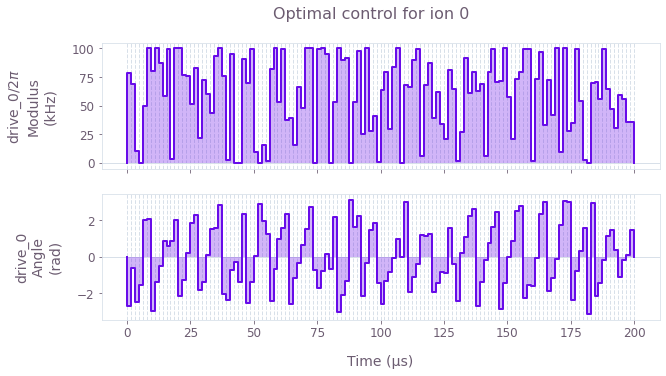

In [17]:
print(f"Resulting phases: \n {optimization_result['output']['phases']['value'][-1]}")
print(f"Target phases: \n {target_phases}")
qv.plot_controls({"drive_0": optimization_result["output"]["drive_0"]})
plt.suptitle("Optimal control for ion 0")
plt.show()

### Plot gate dynamics

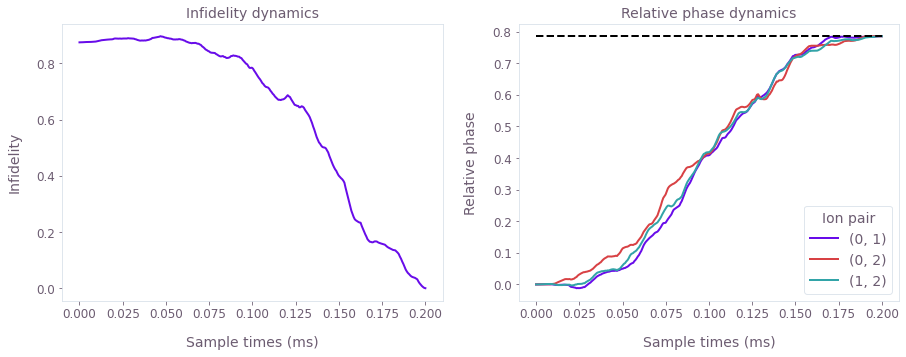

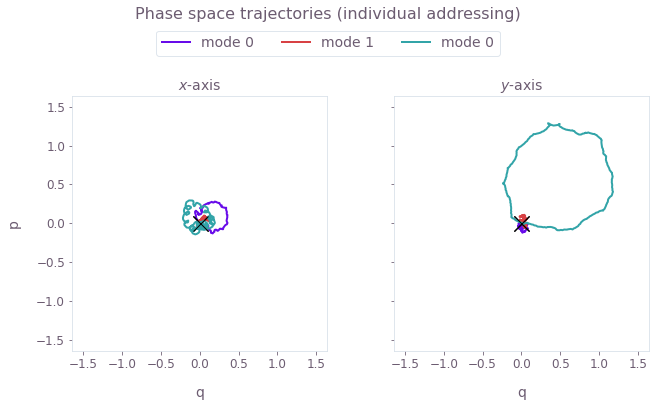

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
times = sample_times * 1e3

axes[0].plot(times, optimization_result["output"]["infidelities"]["value"])
axes[0].set_title("Infidelity dynamics")
axes[0].set_xlabel("Sample times (ms)")
axes[0].set_ylabel("Infidelity")

# Recall that the phases are stored as a strictly lower triangular matrix.
# See the notes part of the ms_phases graph operation.
phases = optimization_result["output"]["phases"]["value"]
for ion_1 in range(3):
    for ion_2 in range(ion_1):
        axes[1].plot(times, phases[:, ion_1, ion_2], label=f"{ion_2, ion_1}")
axes[1].plot([0, times[-1]], [np.pi / 4, np.pi / 4], "k--")
axes[1].set_title("Relative phase dynamics")
axes[1].set_xlabel("Sample times (ms)")
axes[1].set_ylabel("Relative phase")
axes[1].legend(title="Ion pair")

# Mode displacement trajectories for radial dimensions.
plot_phase_space_trajectories(
    np.sum(optimization_result["output"]["displacements"]["value"], axis=-1),
    "individual addressing",
)

The above figure shows the infidelity and relative phases over the gate duration (top), as well as the motional phase space trajectories (bottom), which are closed loops indicating no final displacement for each mode.

### Summary

In these examples, you have seen how Boulder Opal can easily calculate the important physical properties for your ion trap, efficiently find optimal or robust drives for state preparation, and track the ion states in phase space at any sample points during the gate operational time.

You can apply the same optimization strategy to large systems involving tens of qubits.
This process is demonstrated in the [Designing robust, configurable, parallel gates for large trapped-ion arrays](https://docs.q-ctrl.com/boulder-opal/application-notes/designing-robust-configurable-parallel-gates-for-large-trapped-ion-arrays) application note, where you will learn about how the Boulder Opal optimization engine enables you to efficiently find optimal and noise-robust control pulses for large trapped ion systems.